# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation
from keras.layers.merge import Concatenate
from keras import losses 
from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from util import random_mask
from pconv import PConv2D
%matplotlib inline

# Settings
MAX_BATCH_SIZE = 128

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
from pconv import PConv2D

class PConvUnet(object):

    def __init__(self, img_rows=512, img_cols=512):
        """Create the PConvUnet. If variable image size, set img_rows and img_cols to None"""
        
        # Settings
        self.img_rows = img_rows
        self.img_cols = img_cols
        assert self.img_rows >= 512, 'Height must be >512 pixels'
        assert self.img_cols >= 512, 'Width must be >512 pixels'
        
        # Create model
        self.model = self.get_pconv_unet()
        
    def get_pconv_unet(self):
        print(">> Now creating Partial Conv U-Net Model")        
        inputs_img = Input((self.img_rows, self.img_cols, 3))
        inputs_mask = Input((self.img_rows, self.img_cols, 3))
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization()(conv)
            conv = Activation('relu')(conv)
            return conv, mask
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_img = LeakyReLU(alpha=0.2)(up_img)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid')(d_conv16)
        
        # Compile the model
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)
        model.compile(
            optimizer = Adam(lr = 1e-4),
            loss=self.loss_total(inputs_mask)
        )

        return model
    
    def loss_total(self, mask):
        def loss(y_true, y_pred):
            return self.loss_valid(mask, y_true, y_pred) + 6*self.loss_hole(mask, y_true, y_pred)
        return loss
    
    @staticmethod
    def loss_hole(mask, y_true, y_pred):
        return losses.mean_absolute_error((1-mask) * y_true, (1-mask) * y_pred)
    
    @staticmethod
    def loss_valid(mask, y_true, y_pred):
        return losses.mean_absolute_error(mask * y_true, mask * y_pred)
    
    @staticmethod
    def loss_perceptual(y_true, y_pred):
        pass
    
    @staticmethod
    def loss_style_out(y_true, y_pred):
        pass
    
    @staticmethod
    def loss_style_comp(y_true, y_pred):
        pass
    
    @staticmethod
    def loss_style_tv(y_true, y_pred):
        pass

    def fit(self, generator, epochs=10, test_imgs=None, *args, **kwargs):
        """Fit the U-Net to a (images, targets) generator
        
        param generator: training generator yielding (maskes_image, original_image) tuples
        param epochs: number of epochs to train for
        param test_imgs: list of (masked_img, original_img) tuples to test each epoch
        """
        
        # Loop over epochs
        for i in range(epochs):
            print(f">> Fitting epoch {i+1}")
            
            # Fit the model
            self.model.fit_generator(
                generator,
                epochs=i+1,
                initial_epoch=i,
                *args, **kwargs
            )
            
            # After each epoch predict on test images & show them
            for test in test_imgs:
                
                # Get samples & Display them
                (mask_img, mask), ori_img = test 
                pred_img = model.predict([mask_img, mask])

                _, axes = plt.subplots(1, 3, figsize=(20, 5))
                axes[0].imshow(mask_img[0,:,:,:])
                axes[1].imshow(pred_img[0,:,:,:])
                axes[2].imshow(ori_img[0,:,:,:])
                axes[0].set_title('Masked Image')
                axes[1].set_title('Predicted Image')
                axes[2].set_title('Original Image')
                plt.show()
            
    def predict(self, sample):
        return self.model.predict(sample)
    
PConvUnet().model.summary()

>> Now creating Partial Conv U-Net Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 256, 256, 64 9472        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           p_c

# Testing out on single image

Shape of image is: (512, 512, 3)


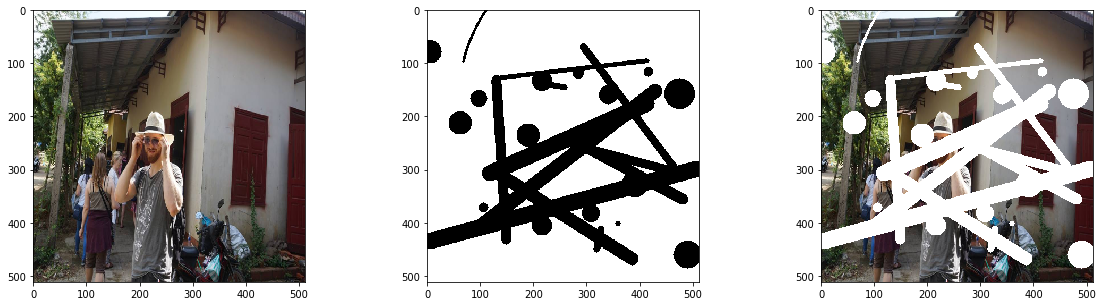

In [4]:
# Load image
img = cv2.imread('../data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

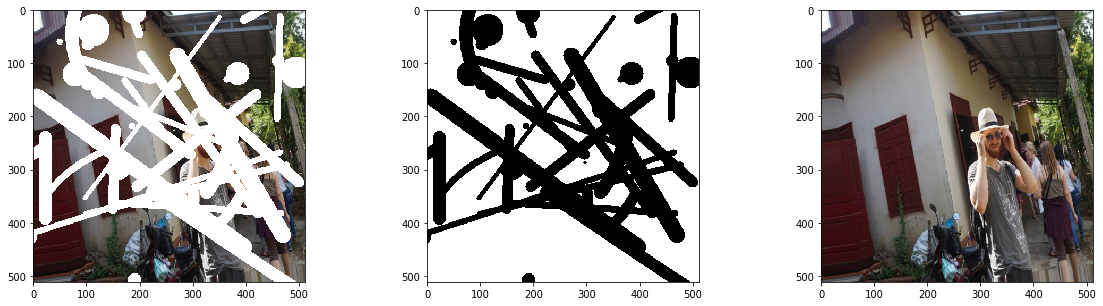

In [5]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=8)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

>> Now creating Partial Conv U-Net Model
>> Fitting epoch 1
Epoch 1/1
100/100 [==============================] - 66s 656ms/step - loss: 0.2356


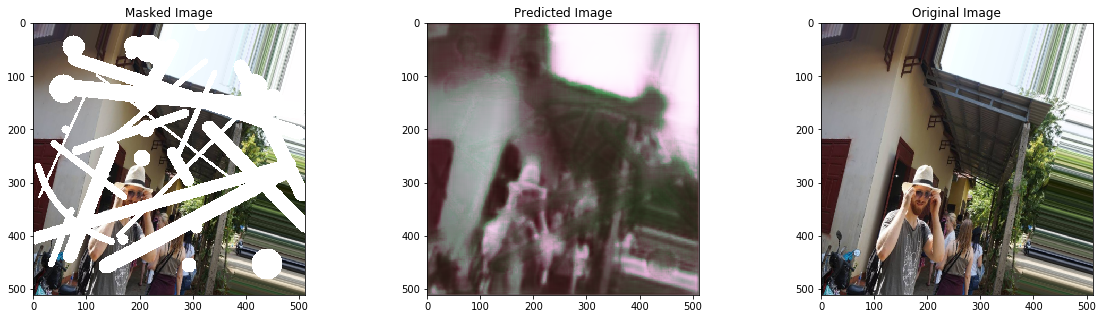

>> Fitting epoch 2
Epoch 2/2
 75/100 [=====================>........] - ETA: 18s - loss: 0.1585

In [ ]:
model = PConvUnet()
model.fit(
    generator, 
    steps_per_epoch=100,
    epochs=10,    
    test_imgs=[next(generator)],
    workers=2
)